Visión Artificial - Tema 4 (Aplicación a Imágenes 2D)
Ruido, Procesos Estocásticos y Entropía

¿Deseas subir tu propia imagen o usar una imagen sintética?
Opciones:
  1. Subir mi propia imagen
  2. Usar imagen sintética generada automáticamente

✓ Entorno Google Colab detectado

Ingresa tu opción (1 o 2): 1

📤 Por favor, sube tu imagen (formatos: JPG, PNG, BMP, etc.)


Saving robot1.jpeg to robot1.jpeg

✓ Imagen cargada: robot1.jpeg
  Convirtiendo a escala de grises...
✓ Imagen lista: (512, 512)

Información de la imagen:
  Dimensiones: (512, 512)
  Rango de valores: [0, 254]


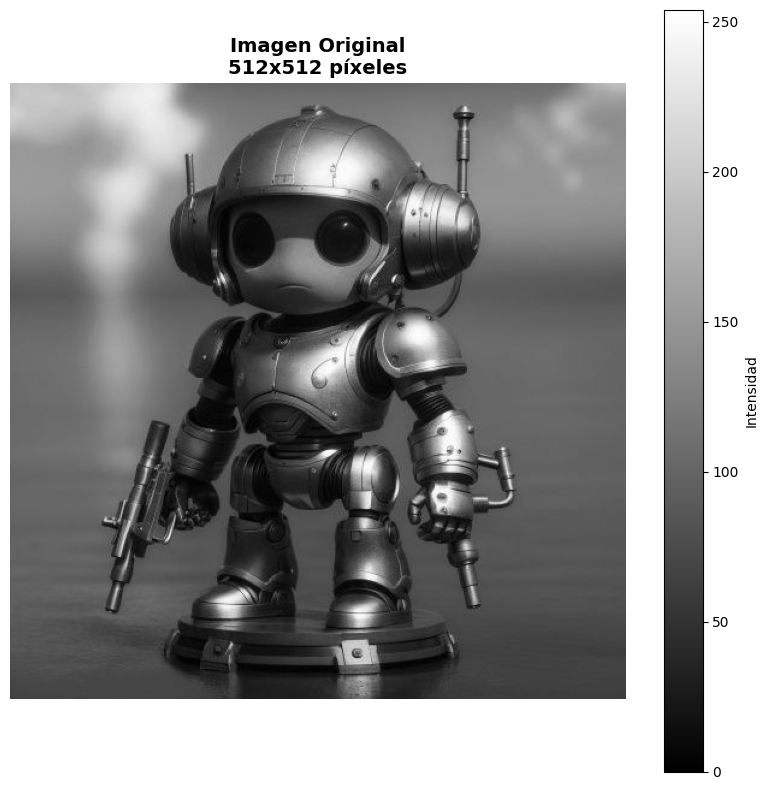


[1/7] Aplicando Ruido Blanco Gaussiano...


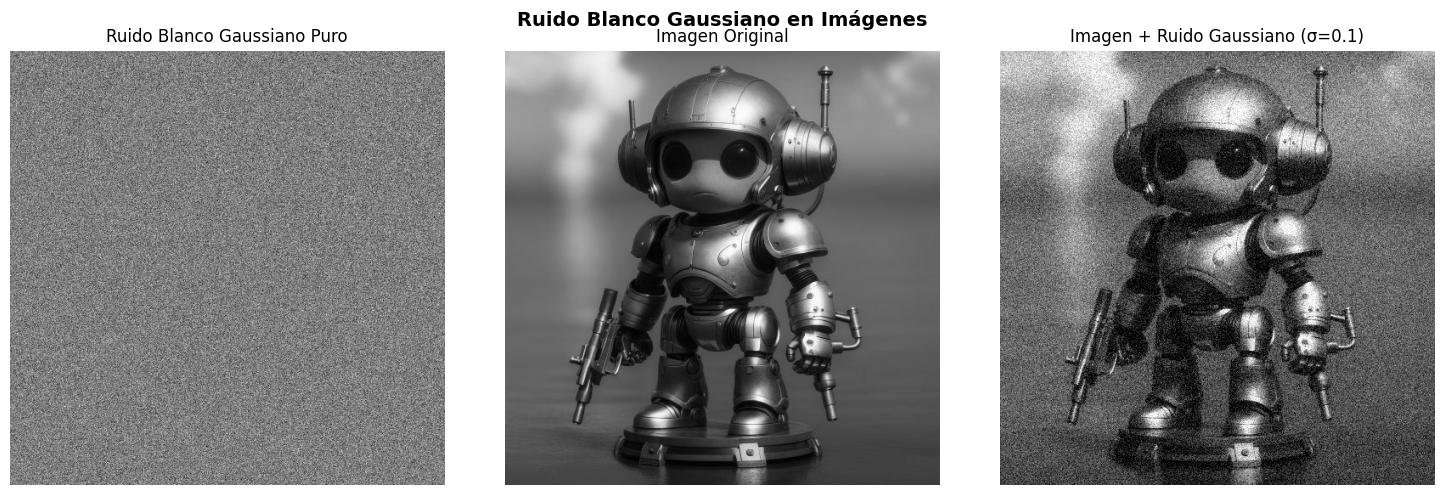

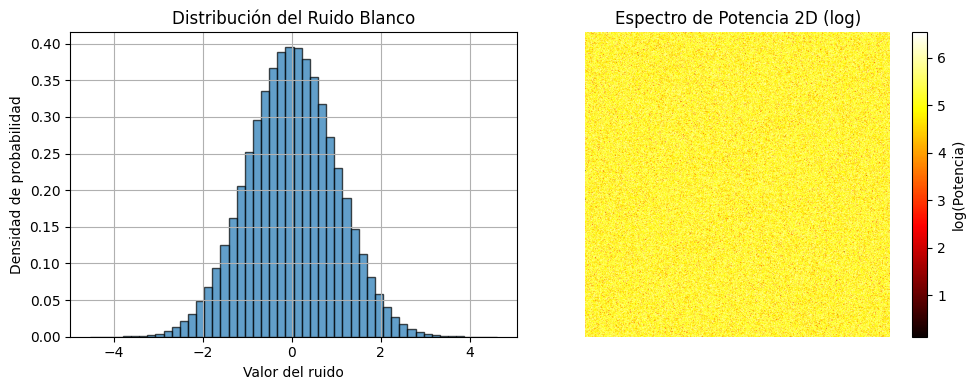

✓ Ruido blanco gaussiano aplicado

[2/7] Aplicando Ruido Rosa (1/f)...


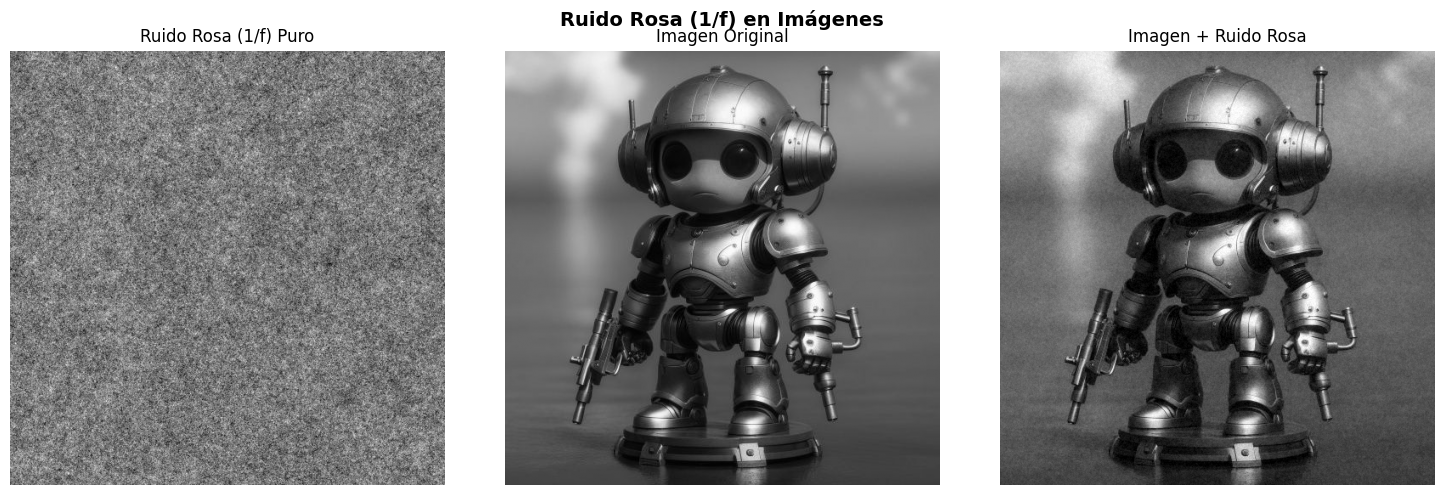

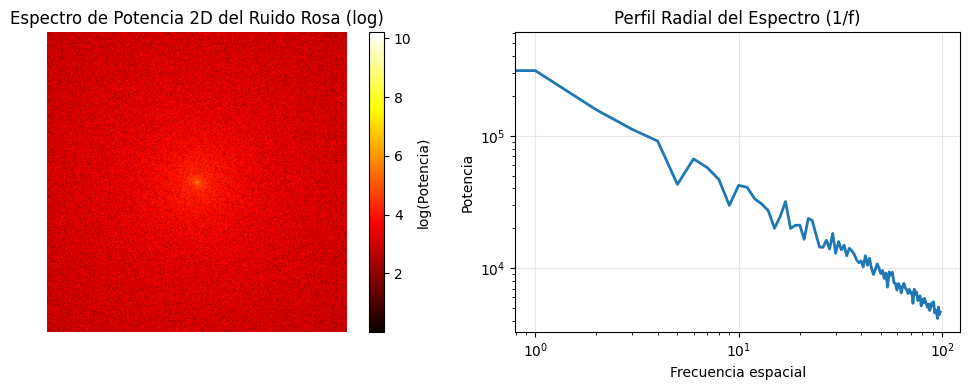

✓ Ruido rosa aplicado

[3/7] Aplicando Ruido de Disparo (Poisson)...


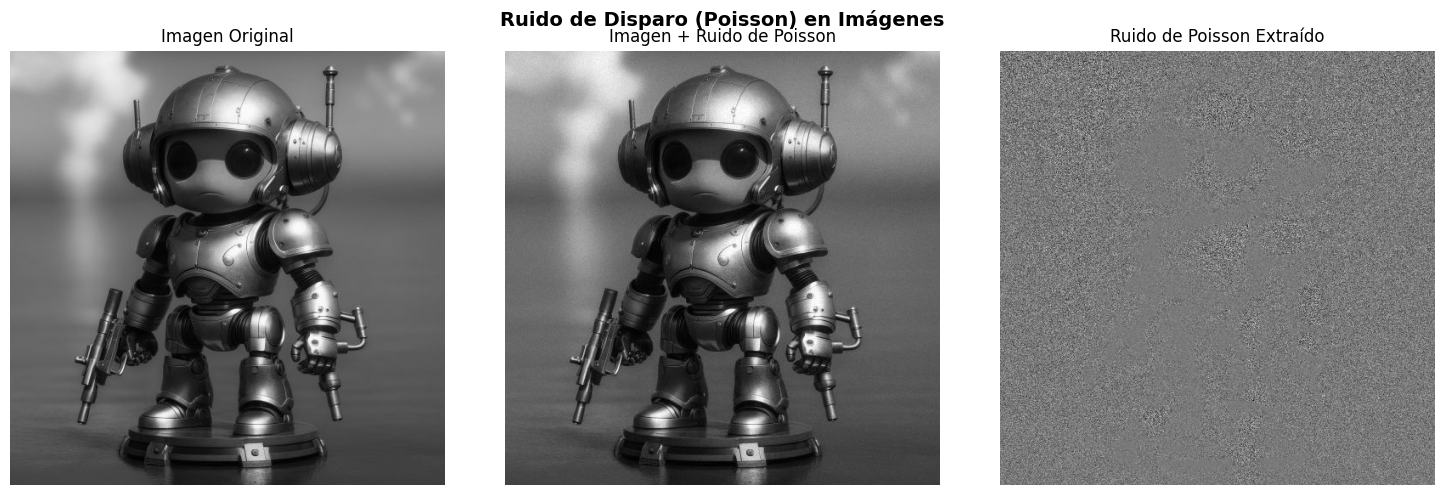

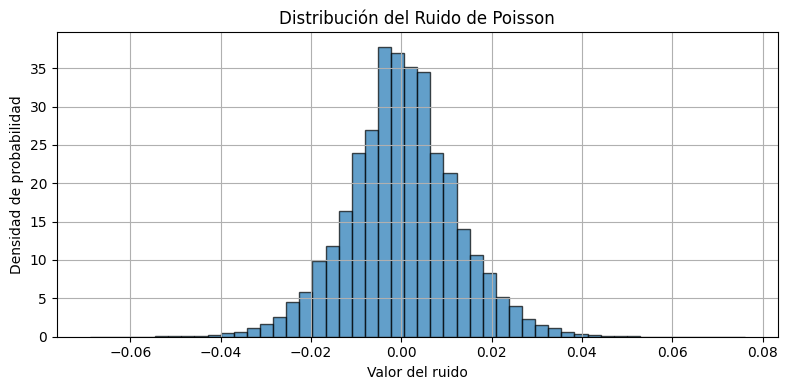

✓ Ruido de Poisson aplicado

[4/7] Aplicando Ruido Sal y Pimienta...


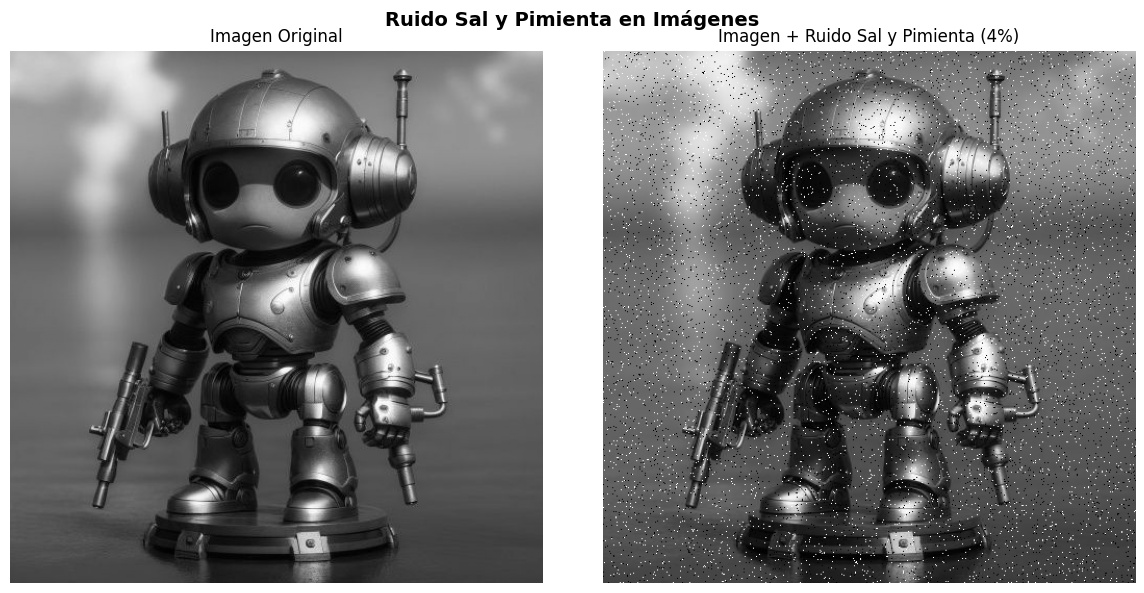

✓ Ruido sal y pimienta aplicado

[5/7] Comparando diferentes niveles de SNR...


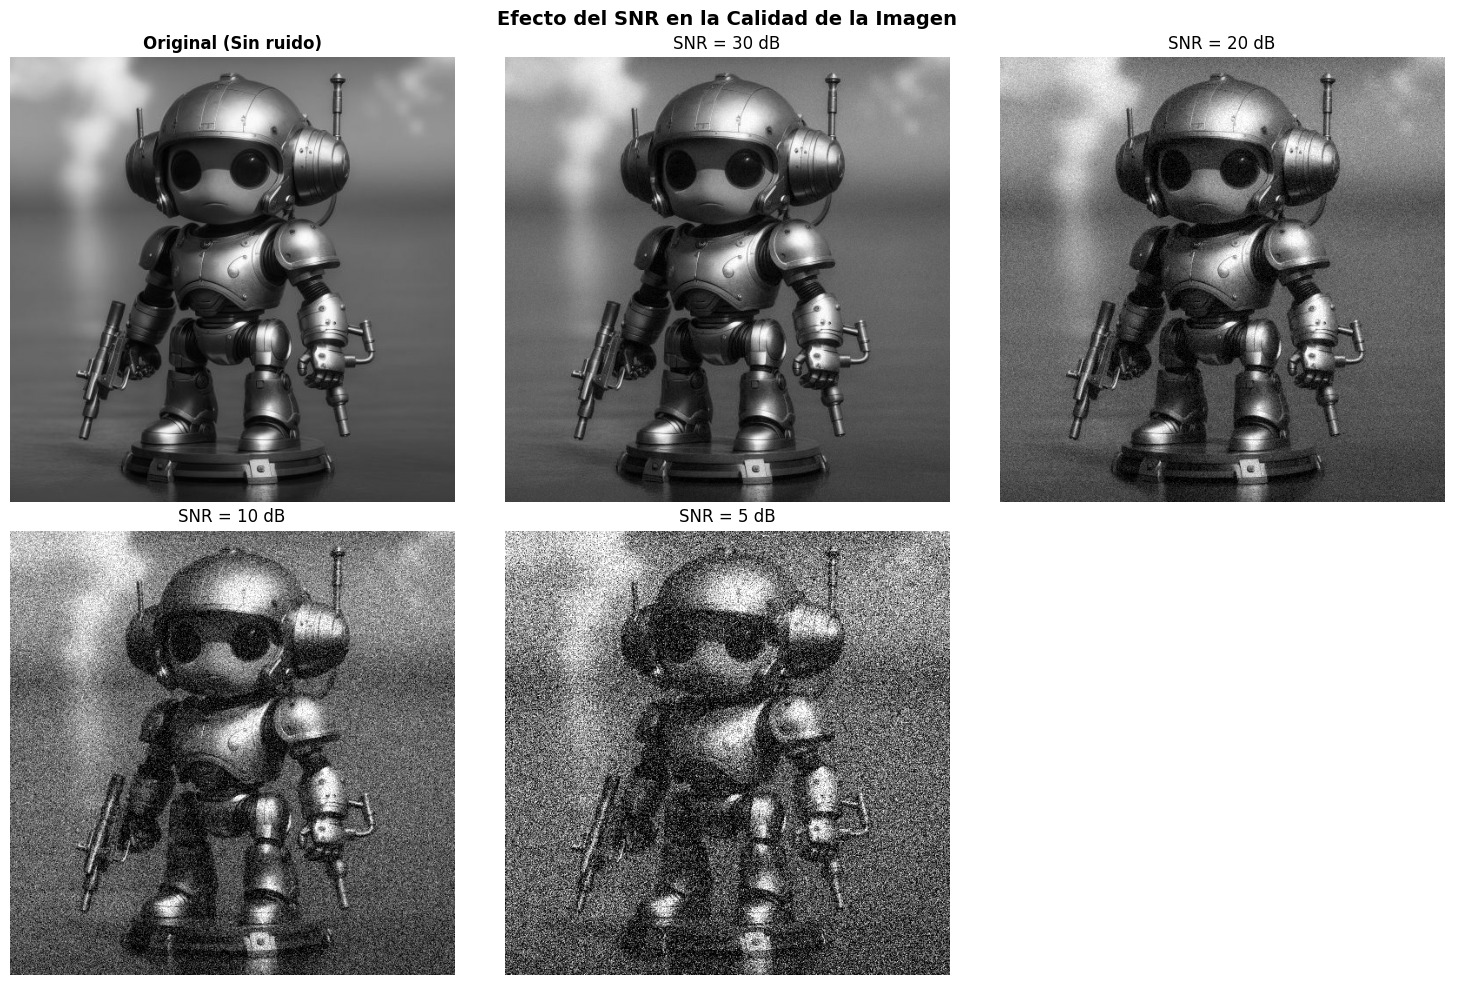

✓ Comparación de SNR completada

[6/7] Calculando Entropía de Shannon...
✓ Entropía de Shannon:
  Imagen original: 7.5280 bits
  Con ruido gaussiano: 7.6270 bits
  Con ruido sal y pimienta: 7.5093 bits


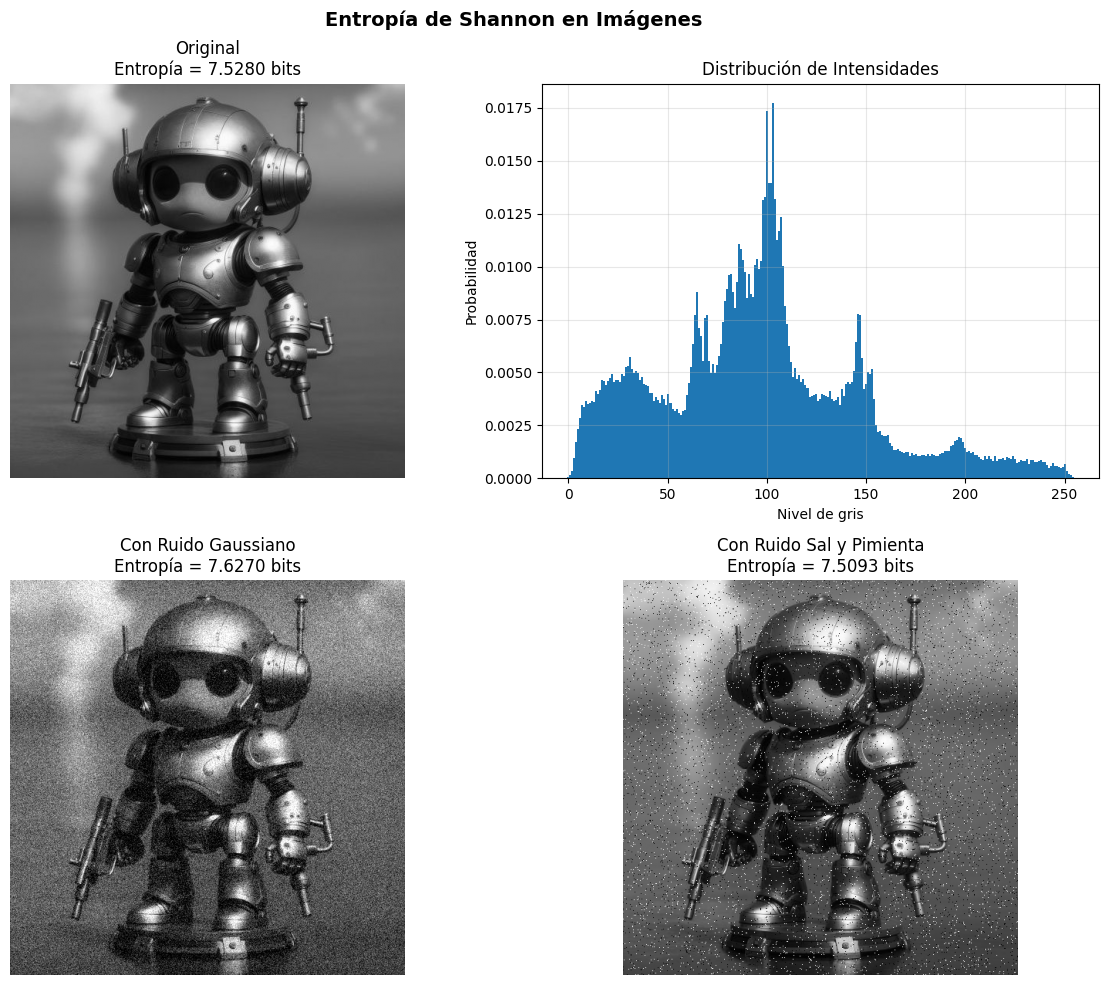


[7/7] Calculando Entropía Local...


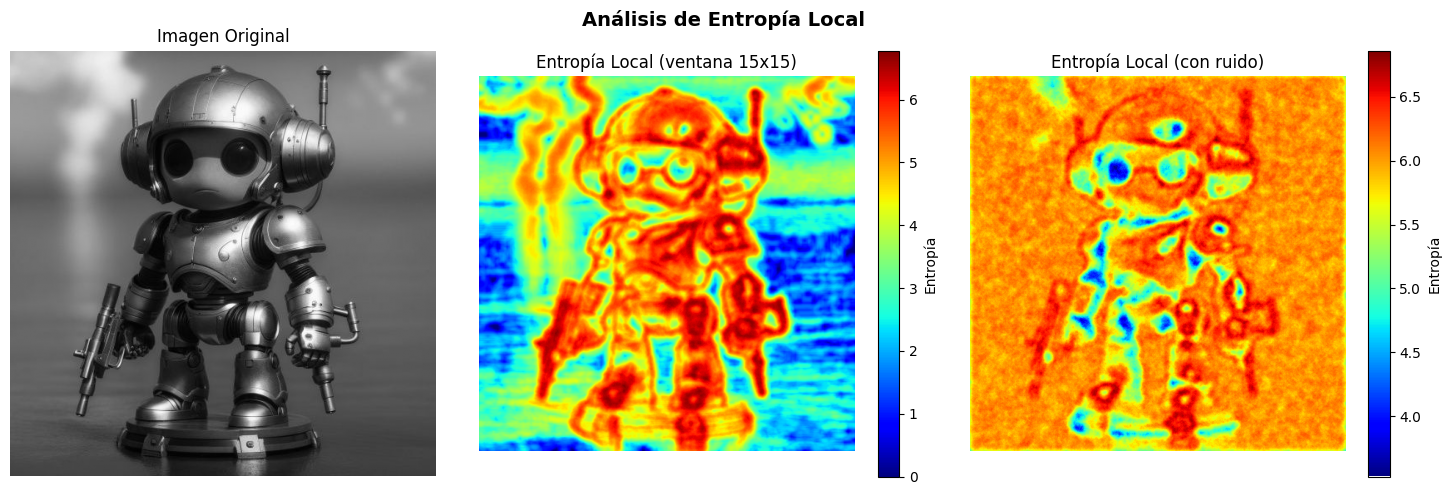

✓ Entropía local calculada

ANÁLISIS COMPLETADO

Resumen de análisis realizados:
  1. Ruido Blanco Gaussiano - Distribución normal en cada píxel
  2. Ruido Rosa (1/f) - Mayor energía en bajas frecuencias
  3. Ruido de Poisson - Modelado de ruido de disparo
  4. Ruido Sal y Pimienta - Píxeles aleatorios blancos/negros
  5. Comparación SNR - Efecto del ruido en diferentes niveles
  6. Entropía de Shannon - Medida de información en la imagen
  7. Entropía Local - Complejidad espacial de la imagen

Todos los análisis han sido completados correctamente.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal, ndimage
from scipy.stats import poisson
import io
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['image.cmap'] = 'gray'

print("="*70)
print("Visión Artificial - Tema 4 (Aplicación a Imágenes 2D)")
print("Ruido, Procesos Estocásticos y Entropía")
print("="*70)

# ==============================================================================
# CARGAR IMAGEN
# ==============================================================================

print("\n¿Deseas subir tu propia imagen o usar una imagen sintética?")
print("Opciones:")
print("  1. Subir mi propia imagen")
print("  2. Usar imagen sintética generada automáticamente")

try:
    from google.colab import files
    EN_COLAB = True
    print("\n✓ Entorno Google Colab detectado")
except ImportError:
    EN_COLAB = False
    print("\n⚠ No se detectó Google Colab. Se usará imagen sintética por defecto.")

usar_imagen_propia = False

if EN_COLAB:
    opcion = input("\nIngresa tu opción (1 o 2): ").strip()

    if opcion == "1":
        print("\n📤 Por favor, sube tu imagen (formatos: JPG, PNG, BMP, etc.)")
        uploaded = files.upload()

        if uploaded:
            filename = list(uploaded.keys())[0]
            print(f"\n✓ Imagen cargada: {filename}")

            imagen_original = Image.open(io.BytesIO(uploaded[filename]))

            # Convertir a escala de grises
            if imagen_original.mode != 'L':
                print("  Convirtiendo a escala de grises...")
                imagen_original = imagen_original.convert('L')

            imagen_original = np.array(imagen_original)

            # Redimensionar si es muy grande
            max_size = 512
            if imagen_original.shape[0] > max_size or imagen_original.shape[1] > max_size:
                print(f"  Redimensionando imagen a máximo {max_size}x{max_size}...")
                ratio = min(max_size / imagen_original.shape[0], max_size / imagen_original.shape[1])
                new_size = (int(imagen_original.shape[1] * ratio), int(imagen_original.shape[0] * ratio))
                img_pil = Image.fromarray(imagen_original)
                img_pil = img_pil.resize(new_size, Image.BILINEAR)
                imagen_original = np.array(img_pil)

            usar_imagen_propia = True
            print(f"✓ Imagen lista: {imagen_original.shape}")
        else:
            print("\n⚠ No se subió ninguna imagen. Usando imagen sintética.")

# Generar imagen sintética si no se cargó una
if not usar_imagen_propia:
    print("\n[Generando imagen sintética...]")
    size = 512
    x = np.linspace(0, 4*np.pi, size)
    y = np.linspace(0, 4*np.pi, size)
    X, Y = np.meshgrid(x, y)

    imagen_original = (np.sin(X) + np.sin(Y) +
                       0.5*np.sin(3*X) + 0.5*np.sin(3*Y) +
                       0.3*np.sin(5*X + 5*Y))

    imagen_original = ((imagen_original - imagen_original.min()) /
                       (imagen_original.max() - imagen_original.min()) * 255).astype(np.uint8)

    print(f"✓ Imagen sintética creada: {imagen_original.shape}")

# Normalizar a rango [0, 1] para procesamiento
img = imagen_original.astype(float) / 255.0

print(f"\nInformación de la imagen:")
print(f"  Dimensiones: {imagen_original.shape}")
print(f"  Rango de valores: [{imagen_original.min()}, {imagen_original.max()}]")

# Mostrar imagen original
plt.figure(figsize=(8, 8))
plt.imshow(imagen_original, cmap='gray')
titulo = 'Imagen Original' if usar_imagen_propia else 'Imagen Original (Sintética)'
plt.title(f'{titulo}\n{imagen_original.shape[0]}x{imagen_original.shape[1]} píxeles',
          fontsize=14, fontweight='bold')
plt.colorbar(label='Intensidad')
plt.axis('off')
plt.tight_layout()
plt.show()

# ==============================================================================
# 1. RUIDO BLANCO GAUSSIANO
# ==============================================================================

print("\n[1/7] Aplicando Ruido Blanco Gaussiano...")

def add_gaussian_noise(image, mean=0, sigma=0.1):
    """Añade ruido gaussiano a una imagen"""
    noise = np.random.normal(mean, sigma, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)

# Generar ruido blanco puro
white_noise = np.random.randn(*img.shape)

# Aplicar ruido gaussiano a la imagen
img_gaussian = add_gaussian_noise(img, sigma=0.1)

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(white_noise, cmap='gray')
axes[0].set_title('Ruido Blanco Gaussiano Puro')
axes[0].axis('off')

axes[1].imshow(img, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Imagen Original')
axes[1].axis('off')

axes[2].imshow(img_gaussian, cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Imagen + Ruido Gaussiano (σ=0.1)')
axes[2].axis('off')

plt.suptitle('Ruido Blanco Gaussiano en Imágenes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Histograma del ruido
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(white_noise.flatten(), bins=50, density=True, alpha=0.7, edgecolor='black')
plt.xlabel('Valor del ruido')
plt.ylabel('Densidad de probabilidad')
plt.title('Distribución del Ruido Blanco')
plt.grid(True)

# Espectro de potencia 2D
plt.subplot(1, 2, 2)
fft_noise = np.fft.fft2(white_noise)
psd_noise = np.abs(np.fft.fftshift(fft_noise))**2
plt.imshow(np.log10(psd_noise + 1), cmap='hot')
plt.title('Espectro de Potencia 2D (log)')
plt.colorbar(label='log(Potencia)')
plt.axis('off')
plt.tight_layout()
plt.show()

print("✓ Ruido blanco gaussiano aplicado")

# ==============================================================================
# 2. RUIDO ROSA (1/f)
# ==============================================================================

print("\n[2/7] Aplicando Ruido Rosa (1/f)...")

def pink_noise_2d(shape):
    """Genera ruido rosa 2D con espectro 1/f"""
    # Generar ruido blanco
    white = np.random.randn(*shape)

    # FFT 2D
    fft_white = np.fft.fft2(white)

    # Crear filtro 1/f
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2

    y, x = np.ogrid[:rows, :cols]
    dist = np.sqrt((x - ccol)**2 + (y - crow)**2)
    dist[crow, ccol] = 1  # Evitar división por cero

    # Aplicar filtro 1/sqrt(f)
    fft_pink = fft_white / np.fft.fftshift(np.sqrt(dist))

    # IFFT
    pink = np.fft.ifft2(fft_pink).real

    # Normalizar
    pink = (pink - pink.min()) / (pink.max() - pink.min())

    return pink

# Generar ruido rosa
pink_noise = pink_noise_2d(img.shape)

# Aplicar a la imagen
img_pink = np.clip(img + 0.2 * (pink_noise - 0.5), 0, 1)

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(pink_noise, cmap='gray')
axes[0].set_title('Ruido Rosa (1/f) Puro')
axes[0].axis('off')

axes[1].imshow(img, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Imagen Original')
axes[1].axis('off')

axes[2].imshow(img_pink, cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Imagen + Ruido Rosa')
axes[2].axis('off')

plt.suptitle('Ruido Rosa (1/f) en Imágenes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Espectro de potencia
fft_pink = np.fft.fft2(pink_noise)
psd_pink = np.abs(np.fft.fftshift(fft_pink))**2

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(psd_pink + 1), cmap='hot')
plt.title('Espectro de Potencia 2D del Ruido Rosa (log)')
plt.colorbar(label='log(Potencia)')
plt.axis('off')

# Perfil radial del espectro
plt.subplot(1, 2, 2)
rows, cols = img.shape
crow, ccol = rows // 2, cols // 2
y, x = np.ogrid[:rows, :cols]
r = np.sqrt((x - ccol)**2 + (y - crow)**2).astype(int)
radial_profile = ndimage.mean(psd_pink, labels=r, index=np.arange(0, r.max()))
plt.loglog(radial_profile[1:100], linewidth=2)
plt.xlabel('Frecuencia espacial')
plt.ylabel('Potencia')
plt.title('Perfil Radial del Espectro (1/f)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Ruido rosa aplicado")

# ==============================================================================
# 3. RUIDO DE DISPARO (SHOT NOISE / POISSON)
# ==============================================================================

print("\n[3/7] Aplicando Ruido de Disparo (Poisson)...")

def add_poisson_noise(image, scale=1.0):
    """Añade ruido de Poisson a una imagen"""
    # Escalar la imagen para controlar la intensidad del ruido
    scaled = image * 255 * scale
    # Aplicar ruido de Poisson
    noisy = np.random.poisson(scaled) / scale / 255
    return np.clip(noisy, 0, 1)

# Aplicar ruido de Poisson
img_poisson = add_poisson_noise(img, scale=10)

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Imagen Original')
axes[0].axis('off')

axes[1].imshow(img_poisson, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Imagen + Ruido de Poisson')
axes[1].axis('off')

# Diferencia (ruido)
noise_poisson = img_poisson - img
axes[2].imshow(noise_poisson, cmap='gray')
axes[2].set_title('Ruido de Poisson Extraído')
axes[2].axis('off')

plt.suptitle('Ruido de Disparo (Poisson) en Imágenes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Histograma del ruido
plt.figure(figsize=(8, 4))
plt.hist(noise_poisson.flatten(), bins=50, density=True, alpha=0.7, edgecolor='black')
plt.xlabel('Valor del ruido')
plt.ylabel('Densidad de probabilidad')
plt.title('Distribución del Ruido de Poisson')
plt.grid(True)
plt.tight_layout()
plt.show()

print("✓ Ruido de Poisson aplicado")

# ==============================================================================
# 4. RUIDO SAL Y PIMIENTA
# ==============================================================================

print("\n[4/7] Aplicando Ruido Sal y Pimienta...")

def add_salt_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    """Añade ruido sal y pimienta a una imagen"""
    noisy = image.copy()

    # Sal (píxeles blancos)
    salt_mask = np.random.random(image.shape) < salt_prob
    noisy[salt_mask] = 1

    # Pimienta (píxeles negros)
    pepper_mask = np.random.random(image.shape) < pepper_prob
    noisy[pepper_mask] = 0

    return noisy

# Aplicar ruido sal y pimienta
img_sp = add_salt_pepper_noise(img, salt_prob=0.02, pepper_prob=0.02)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Imagen Original')
axes[0].axis('off')

axes[1].imshow(img_sp, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Imagen + Ruido Sal y Pimienta (4%)')
axes[1].axis('off')

plt.suptitle('Ruido Sal y Pimienta en Imágenes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Ruido sal y pimienta aplicado")

# ==============================================================================
# 5. IMAGEN CON DIFERENTES NIVELES DE SNR
# ==============================================================================

print("\n[5/7] Comparando diferentes niveles de SNR...")

def add_noise_with_snr(image, snr_db):
    """Añade ruido gaussiano con SNR específico"""
    signal_power = np.mean(image**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear
    noise_std = np.sqrt(noise_power)

    noise = np.random.randn(*image.shape) * noise_std
    noisy = image + noise

    return np.clip(noisy, 0, 1)

# Diferentes niveles de SNR
snr_levels = [30, 20, 10, 5]
noisy_images = [add_noise_with_snr(img, snr) for snr in snr_levels]

# Visualización
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img, cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title('Original (Sin ruido)', fontweight='bold')
axes[0, 0].axis('off')

for idx, (snr, noisy_img) in enumerate(zip(snr_levels, noisy_images)):
    row = (idx + 1) // 3
    col = (idx + 1) % 3
    axes[row, col].imshow(noisy_img, cmap='gray', vmin=0, vmax=1)
    axes[row, col].set_title(f'SNR = {snr} dB')
    axes[row, col].axis('off')

# Ocultar subplot vacío
axes[1, 2].axis('off')

plt.suptitle('Efecto del SNR en la Calidad de la Imagen', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Comparación de SNR completada")

# ==============================================================================
# 6. ENTROPÍA DE SHANNON DE LA IMAGEN
# ==============================================================================

print("\n[6/7] Calculando Entropía de Shannon...")

def shannon_entropy_image(image):
    """Calcula la entropía de Shannon de una imagen"""
    # Convertir a valores enteros 0-255
    img_int = (image * 255).astype(np.uint8)

    # Calcular histograma
    hist, _ = np.histogram(img_int, bins=256, range=(0, 256))

    # Normalizar para obtener probabilidades
    hist = hist / hist.sum()

    # Eliminar bins vacíos
    hist = hist[hist > 0]

    # Calcular entropía
    entropy = -np.sum(hist * np.log2(hist))

    return entropy, hist

# Calcular entropía de la imagen original
entropy_orig, hist_orig = shannon_entropy_image(img)

# Calcular entropía de imágenes con ruido
entropy_gaussian, _ = shannon_entropy_image(img_gaussian)
entropy_sp, _ = shannon_entropy_image(img_sp)

print(f"✓ Entropía de Shannon:")
print(f"  Imagen original: {entropy_orig:.4f} bits")
print(f"  Con ruido gaussiano: {entropy_gaussian:.4f} bits")
print(f"  Con ruido sal y pimienta: {entropy_sp:.4f} bits")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Imagen original
axes[0, 0].imshow(img, cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title(f'Original\nEntropía = {entropy_orig:.4f} bits')
axes[0, 0].axis('off')

# Histograma
axes[0, 1].bar(range(len(hist_orig)), hist_orig, width=1, edgecolor='none')
axes[0, 1].set_xlabel('Nivel de gris')
axes[0, 1].set_ylabel('Probabilidad')
axes[0, 1].set_title('Distribución de Intensidades')
axes[0, 1].grid(True, alpha=0.3)

# Imagen con ruido gaussiano
axes[1, 0].imshow(img_gaussian, cmap='gray', vmin=0, vmax=1)
axes[1, 0].set_title(f'Con Ruido Gaussiano\nEntropía = {entropy_gaussian:.4f} bits')
axes[1, 0].axis('off')

# Imagen con ruido sal y pimienta
axes[1, 1].imshow(img_sp, cmap='gray', vmin=0, vmax=1)
axes[1, 1].set_title(f'Con Ruido Sal y Pimienta\nEntropía = {entropy_sp:.4f} bits')
axes[1, 1].axis('off')

plt.suptitle('Entropía de Shannon en Imágenes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==============================================================================
# 7. ENTROPÍA LOCAL (VENTANA DESLIZANTE)
# ==============================================================================

print("\n[7/7] Calculando Entropía Local...")

def local_entropy(image, window_size=9):
    """Calcula la entropía local usando una ventana deslizante"""
    from skimage.filters.rank import entropy
    from skimage.morphology import disk

    # Convertir a uint8
    img_uint8 = (image * 255).astype(np.uint8)

    # Calcular entropía local
    selem = disk(window_size // 2)
    entr = entropy(img_uint8, selem)

    return entr

try:
    from skimage.filters.rank import entropy as skimage_entropy
    from skimage.morphology import disk

    # Calcular entropía local
    local_entr = local_entropy(img, window_size=15)

    # Visualización
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[0].set_title('Imagen Original')
    axes[0].axis('off')

    im = axes[1].imshow(local_entr, cmap='jet')
    axes[1].set_title('Entropía Local (ventana 15x15)')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], label='Entropía')

    # Imagen con ruido gaussiano
    local_entr_noisy = local_entropy(img_gaussian, window_size=15)
    im2 = axes[2].imshow(local_entr_noisy, cmap='jet')
    axes[2].set_title('Entropía Local (con ruido)')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], label='Entropía')

    plt.suptitle('Análisis de Entropía Local', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("✓ Entropía local calculada")

except ImportError:
    print("⚠ scikit-image no disponible. Implementando versión simplificada...")

    def simple_local_entropy(image, window_size=9):
        """Versión simplificada de entropía local"""
        pad = window_size // 2
        padded = np.pad(image, pad, mode='reflect')
        entropy_map = np.zeros_like(image)

        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                window = padded[i:i+window_size, j:j+window_size]
                window_int = (window * 255).astype(np.uint8)
                hist, _ = np.histogram(window_int, bins=256, range=(0, 256))
                hist = hist[hist > 0] / hist.sum()
                entropy_map[i, j] = -np.sum(hist * np.log2(hist))

        return entropy_map

    # Usar versión simplificada (más lenta)
    print("  Calculando entropía local (esto puede tardar)...")
    # Reducir tamaño para acelerar
    img_small = img[::4, ::4]
    local_entr_small = simple_local_entropy(img_small, window_size=5)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_small, cmap='gray', vmin=0, vmax=1)
    plt.title('Imagen Original (reducida)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    im = plt.imshow(local_entr_small, cmap='jet')
    plt.title('Entropía Local (ventana 5x5)')
    plt.axis('off')
    plt.colorbar(im, label='Entropía')

    plt.suptitle('Análisis de Entropía Local', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("✓ Entropía local calculada (versión simplificada)")

# ==============================================================================
# RESUMEN FINAL
# ==============================================================================

print("\n" + "="*70)
print("ANÁLISIS COMPLETADO")
print("="*70)
print("\nResumen de análisis realizados:")
print("  1. Ruido Blanco Gaussiano - Distribución normal en cada píxel")
print("  2. Ruido Rosa (1/f) - Mayor energía en bajas frecuencias")
print("  3. Ruido de Poisson - Modelado de ruido de disparo")
print("  4. Ruido Sal y Pimienta - Píxeles aleatorios blancos/negros")
print("  5. Comparación SNR - Efecto del ruido en diferentes niveles")
print("  6. Entropía de Shannon - Medida de información en la imagen")
print("  7. Entropía Local - Complejidad espacial de la imagen")
print("\nTodos los análisis han sido completados correctamente.")
print("="*70)